In [6]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
import matplotlib.pyplot as plt
import numpy as np
import igraph
from itertools import combinations
from collections import defaultdict
from scipy.optimize import minimize
import networkx as nx

# Solving the Max-cut problem with Neutral Atoms

### **Victor Onofre**

# Part I: Max-cut problem 

Given a graph  $G = (V, E)$ where:

- $V$ is the set of vertices/nodes
- $E$ is the set of edges

Each edges $e \in E$ is a pair $\{u,v\}$ where $v \in V$ are distinct

####  Example of a graph: 

$$ V = {1,2,3}$$
$$ E = \{\{1,2\}, \{2,3\}, \{1,3\} \} $$

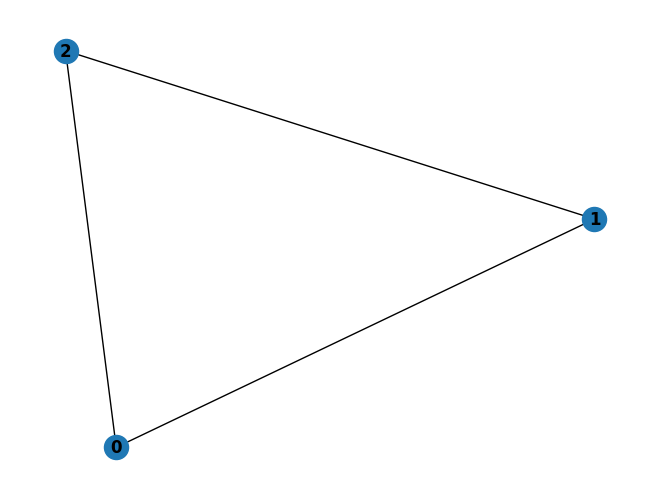

In [28]:
Graph_Example_1 = nx.Graph()
Graph_Example_1.add_edges_from([[0,1],[1,2],[0,2]])
nx.draw(Graph_Example_1,with_labels=True,font_weight='bold')

The goal of the max-cut problem is to:

> **Have as many cut edges as possible. Where an edge is cut if its endpoints have different colors**

The output is a "2-coloring" of $V$: Each vertex is designated a color (examples: blue or red)

The maximum cut can be formaulated as an optimization problem:

$$ \max_{s}\frac{1}{2} \sum_{ij \in E}  (1-s_{i}s_{j}), \quad s_{i} \in \{-1 , +1 \}$$

> Same sign: No edge is cut (no contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 0$

> Different sign: An edge is cut (contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 1$

## Max cut as a QUBO problem

The maximum cut problem can be naturally transformed into the Quadratic unconstrained binary optimization (QUBO) model as follows: 

If we look for a maximum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as many edges as possible between the groups.We can define a binary variable $x_{i}$ for each node:

> $x_{i} = 0 \rightarrow$ The node is in the first subset 

> $x_{i} = 1 \rightarrow$ The node is in the second subset 

Defining the edge_score(i,j) as 1 if the two nodes are in a different subset, 0 otherwise, we can build the followin table: 


| $x_{i}$  | $x_{j}$  |  edge_score(i,j) |  
|---|---|---|
| 0  | 0  | 0  |  
| 0  | 1  | 1  |
| 1  | 0  | 1  |
| 1  | 1  | 1  |

The edge_score is define as $x_{i} + x_{j} - 2 x_{i} x_{j}$. Then for the entire graph, the objective funtion can be written as:

$$ \max \sum_{(i,j) \in E} (x_{i} + x_{j} - 2x_{i}x_{j}) $$

Multiplying by -1 to the convert to a minimization problem: 

$$ \min \sum_{(i,j) \in E} (- x_{i} - x_{j} + 2x_{i}x_{j}) $$

We can build a function to build the QUBO matrix for an arbitrary graph:

In [29]:
def build_qubo_matrix(graph):
    
    #Number of nodes in the graph
    num_nodes = len(graph.nodes) 
    
    # Initialize our QUBO matrix
    Q_matrix = np.zeros((num_nodes, num_nodes))
    
    # Update Q matrix for every edge in the graph
    for i, j in graph.edges:
        Q_matrix[i][i]+= -1
        Q_matrix[j][j]+= -1
        Q_matrix[i][j]+= 2
        
    return Q_matrix

For example, the QUBO matrix for the Max cut problem for the triangle matrix shown at the start of the notebook is: 

In [35]:
Q_matrix_triangular = build_qubo_matrix(Graph_Example_1)
Q_matrix_triangular

array([[-2.,  2.,  2.],
       [ 0., -2.,  2.],
       [ 0.,  0., -2.]])

##  Examples of solutions to the max-cut problem:

### Example 1

In the triangular graph the solution to the max-cut problem is:

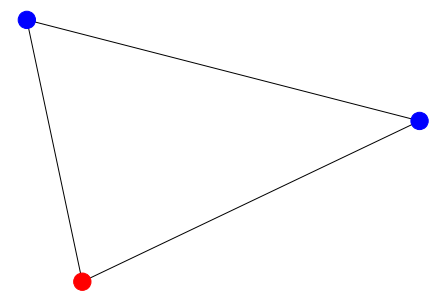

In [4]:
nx.draw(Graph_Example_1,node_color = ['b','b','r'])

Where we a maximum of $2$ cuts. If we assign a string to the colors in the graph we can represent this solution as: $001$. Other combinations with the same number of cuts are $100$ and $010$. 
> Where $0$ is the node blue and $1$ the node is red

If $x$ is one of the binary solutions, the QUBO matrix will give us the total cuts as follows: 

$$ f_{Q} (x) = x^{T}Q x $$

In [39]:
x = np.array([0,1,0])
cost = x.T @ Q_matrix_triangular @ x
cost

-2.0

### Example 2

In this other example the solution to the max-cut problem is:

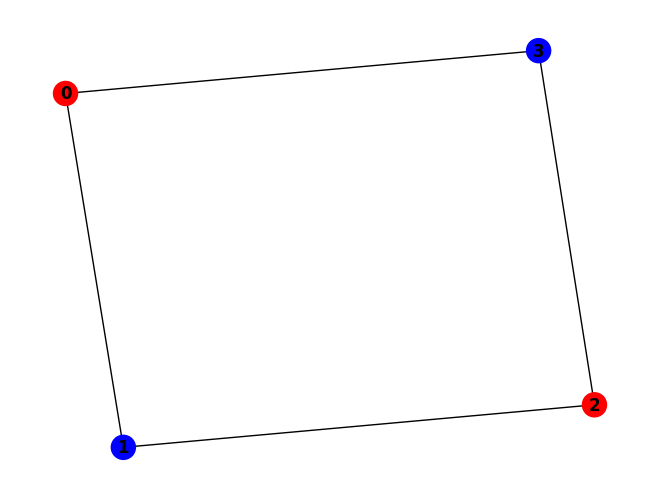

In [50]:
Graph_Example_2 = nx.Graph()
Graph_Example_2.add_edges_from([[0,1],[0,3],[1,2],[2,3]])
nx.draw(Graph_Example_2,with_labels=True,node_color = ['r','b','b','r'],font_weight='bold')

Where we have $4$ cuts. Represented in string as: 1010. Other combination with the same number of cuts are $0101$

In [51]:
Q_matrix_square = build_qubo_matrix(Graph_Example_2)
x = np.array([1,0,1,0])
cost = x.T @ Q_matrix_square @ x
cost

-4.0

### Example 3

In this example the solution to the max-cut problem is:

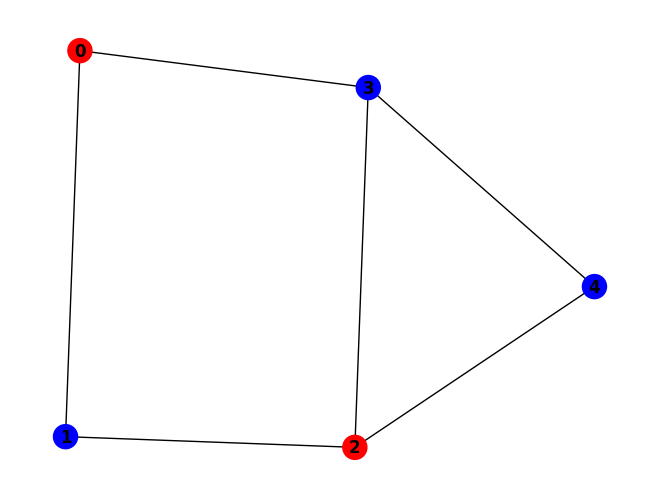

In [57]:
Graph_Example_3 = nx.Graph()
Graph_Example_3.add_edges_from([[0,1],[1,2],[0,3],[3,2],[3,4],[2,4]])
nx.draw(Graph_Example_3,with_labels=True,node_color = ['r','b','r','b','b'],font_weight='bold')

Where, the best solution for the max-cut problem is $5$ cuts. Represented by the string: $10100$. Different combinations with the same number of cuts exist.  

In [59]:
Q_matrix_3 = build_qubo_matrix(Graph_Example_3)
x = np.array([1,0,1,0, 0])
cost = x.T @ Q_matrix_3 @ x
cost

-5.0

## Brute force solution 

In [64]:
def brute_force(qubo_matrix):
    
    bitstrings = [np.binary_repr(i, len(qubo_matrix)) for i in range(2 ** len(qubo_matrix))]
    costs = []
    
    # this takes exponential time with the dimension of the QUBO
    
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q_matrix_3 @ z
        costs.append(cost)
        zipped = zip(bitstrings, costs)
    
    sort_zipped = sorted(zipped, key=lambda x: x[1])
    
    return sort_zipped

In [65]:
print(brute_force(Q_matrix_3 )[:4])

[('01010', -5.0), ('01011', -5.0), ('10100', -5.0), ('10101', -5.0)]


# Part II: Quantum Approximate Optimization Algorithm (QAOA ) with Neutral Atoms

# Part III: Optimization

# Part IV: General Case

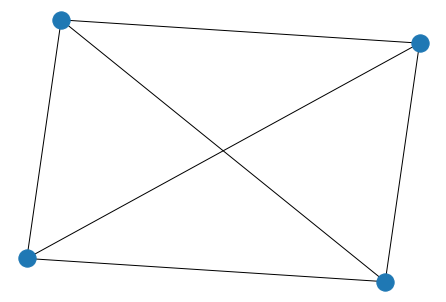

In [31]:
graph2 = nx.random_regular_graph(3, 4, seed=1234)
nx.draw(graph2)          #drawing the graph
plt.show()              #plotting the graph

# **Solution for a random graph of 12 nodes**

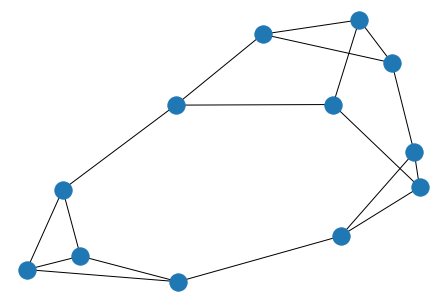

In [33]:
graph3 = nx.random_regular_graph(3, 12, seed=1234)
nx.draw(graph3)          #drawing the graph
plt.show()              #plotting the graph

## References

[1] https://arxiv.org/abs/1411.4028

[2] https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf

[3] https://ieeexplore.ieee.org/document/8939749

[4] https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained